In [13]:
# Python Code for Group Work Machine Learning
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import glob

In [15]:
df_clustered = pd.read_json('df_slim_rotterdam_modified.json', orient='records', lines=True)

In [16]:
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,0
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,0
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,0


In [17]:
# Add the 'entry' column to indicate if the cluster value changes from the previous row
df_clustered['entry'] = (df_clustered['cluster'] != df_clustered['cluster'].shift()).astype(int)

In [18]:
df_clustered = df_clustered.sort_values(by=['vessel.name', 'day', 'hour', 'minute'], ascending=[True, True, True, True])

In [19]:
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster,entry
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,0,1
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,0,0
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0,0
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0,0
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,0,0


In [ ]:
# df_clustered.to_excel('df_clustered_exported.xlsx', index=False, sheet_name='Clustered Data')

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Preprocess the data
features = ['navigation.location.long', 'navigation.location.lat', 'vessel.name', 'day', 'hour'] # speed and course are excluded because of uncertainty

# Encode categorical feature 'vessel.name'
le = LabelEncoder()
df_clustered['vessel.name'] = le.fit_transform(df_clustered['vessel.name'])

# Scale numerical features
scaler = MinMaxScaler()
df_clustered[features[:2]] = scaler.fit_transform(df_clustered[features[:2]])

# Prepare input and output data
X = df_clustered[features].values
y = df_clustered[['cluster', 'entry']].values  # Include both 'cluster' and 'entry' as target

# Reshape input data for LSTM (samples, timesteps, features)
sequence_length = 24  # Define the sequence length
X_lstm = []
y_lstm = []
for i in range(len(X) - sequence_length):
    X_lstm.append(X[i:i + sequence_length])
    y_lstm.append(y[i + sequence_length])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Split data into training and validation sets
train_size = int(0.9 * len(X_lstm))
X_train, X_val = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_val = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
num_features = X_train.shape[2]
num_targets = y_train.shape[1]  # Number of target columns
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=num_targets))  # Output layer with two units for 'cluster' and 'entry'

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_val, y_val))


c:\Users\malyd\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.4837 - val_loss: 1.5006
Epoch 2/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.2321 - val_loss: 0.7133
Epoch 3/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.1825 - val_loss: 0.7932
Epoch 4/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.1344 - val_loss: 0.7490
Epoch 5/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.1042 - val_loss: 0.7166
Epoch 6/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0902 - val_loss: 0.4605
Epoch 7/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0777 - val_loss: 0.5466
Epoch 8/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0665 - val_loss: 0.5289
Epoch 9/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0569 - val_loss: 0.4402
Epoch 10/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0596 - val_loss: 0.3678
Epoch 11/16
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0551 - val_loss: 0.2870
Epoch 12/16
865/865 ━━━━━━━━━━

In [21]:
#Output the number of data points in training, validation, and test dataset.
print("Datapoints in Training set:",len(X_train))
print("Datapoints in validation set:",len(X_val))

Datapoints in Training set: 27677
Datapoints in validation set: 3076


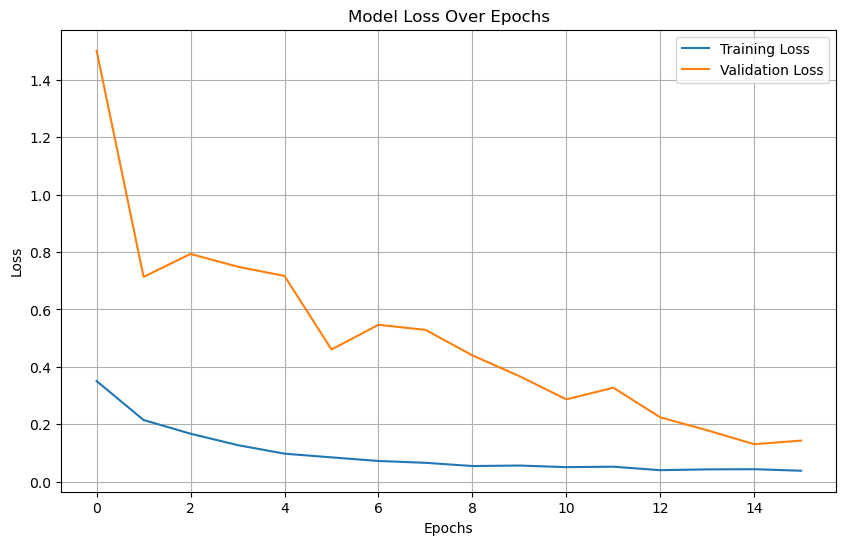

In [22]:
# Visualize the training and validation loss
history = model.history.history 

plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()